
# β<sub>trust</sub> Sweep — 10-Round Average Reward per Setting (All-in-One)

**What this does**
- Imports your local `csmvt_model.py` (same folder)
- Optional: makes the map richer via `ENV_KWARGS`
- Sweeps `beta_trust` values (default 0.0 → 1.0 in 0.1 steps)
- For each β, runs **10 rounds** with a **fresh map per round** and **start resources = 200**
- Saves a CSV and shows a **line plot** (avg reward vs β)

**Output**
- CSV: `./runs/<timestamp>/beta_trust_sweep.csv`
- Inline Matplotlib plot in the final cell


In [1]:

import sys, time, importlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataclasses as dc

# Import model from the same folder
HERE = Path.cwd()
if str(HERE) not in sys.path:
    sys.path.insert(0, str(HERE))

import csmvt_model as model
def reload_model():
    global model
    model = importlib.reload(model)
    return model

# Output paths
RUN_DIR = HERE / "runs" / time.strftime("%Y%m%d_%H%M%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = RUN_DIR / "beta_trust_sweep.csv"
print("Output folder:", RUN_DIR)
print("CSV path:", CSV_PATH)


Output folder: /Users/jianleguo/Documents/GitHub/ITThree_Model/parameter_sweep/runs/20251020_023910
CSV path: /Users/jianleguo/Documents/GitHub/ITThree_Model/parameter_sweep/runs/20251020_023910/beta_trust_sweep.csv


## Parameters (edit here)

In [2]:

# Sweep grid for beta_trust (low -> high). Edit as needed.
BETA_TRUST_VALUES = [round(x, 2) for x in np.linspace(0.0, 1.0, 11)]  # 0.00, 0.10, ..., 1.00

# Forager (MVTConfig) parameters shared across the sweep (beta_trust overwritten per run)
BASE_MVT_PARAMS = dict(
    init_resource=200,
    move_cost=10,
    dig_cost=5,
    gamma=0.1,
    reward_amount=1.0,
    avoid_base=True,
    beta_trust=0.7,          # placeholder; overwritten by sweep value
    label_value={'rich':0.8,'neutral':0.5,'poor':0.2},
    env_factor={'rich':0.8,'neutral':0.5,'poor':0.2},
    mine_choice_value={'rich':1.0,'neutral':0.6,'poor':0.2},
    PI=[1/3, 1/3, 1/3],
    MU=[0.2, 0.6, 0.9],
    SIGMA2=0.05,
    label_to_type={'poor':0, 'neutral':1, 'rich':2},
    baseline_mode="env",
    ewma_eta=0.1,
)

# Explorer parameters (constant across sweep; edit if needed)
EXPLORER_PARAMS = dict(
    init_resource=200,
    move_cost=4,
    scan_cost=2,
    gamma=0.1,
    beta_local=0.6,
    beta_global=0.4,
    avoid_base=True,
    no_backtrack=True,
    cost_sensitive_index=0.1,
)

# Session settings
ENV_SIZE = 3
EXPLORER_STEPS = 100
FORAGER_STEPS = 150
ROUNDS_PER_BETA = 10
SEED = 1

# Optional: make the maps richer
# If your csmvt_model.py was patched to accept **env_kwargs in init_gridworld, set this:
ENV_KWARGS = dict(
    # p_overall=(0.05, 0.25, 0.70),
    # p_mines=(0.10, 0.25, 0.40, 0.25),
)


In [3]:

rows = []
for b in BETA_TRUST_VALUES:
    # Clone params per beta
    MVT_PARAMS = dict(BASE_MVT_PARAMS)
    MVT_PARAMS["beta_trust"] = float(b)

    # Build cfg just for provenance logging
    cfg_log = model.MVTConfig(**MVT_PARAMS)
    params_log = dc.asdict(cfg_log)

    # Run the 10-round fresh-env session for this beta
    session_rows = model.simulate_session_fresh_env(
        cfg_params=MVT_PARAMS,
        exp_params=EXPLORER_PARAMS,
        seed=SEED,
        env_size=ENV_SIZE,
        explorer_steps=EXPLORER_STEPS,
        forager_steps=FORAGER_STEPS,
        n_rounds=ROUNDS_PER_BETA,
        start_resource_explorer=200.0,
        start_resource_forager=200.0,
        **ENV_KWARGS,  # richer-map kwargs (optional)
    )

    # Compute average reward (per-round reward is in 'overall_reward')
    avg_reward = float(pd.DataFrame(session_rows)["overall_reward"].mean())
    rows.append({"beta_trust": b, "avg_reward": avg_reward, **params_log})

df = pd.DataFrame(rows).sort_values("beta_trust").reset_index(drop=True)
df.to_csv(CSV_PATH, index=False)
df.head()


,beta_trust,avg_reward,init_resource,move_cost,dig_cost,gamma,reward_amount,avoid_base,label_value,env_factor,...,stay_leave_temp,move_temp,cost_sensitive_index,K,MU,SIGMA2,PI,label_to_type,baseline_mode,ewma_eta
0,0.0,1.3,200,10,5,0.1,1.0,True,"{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}","{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}",...,0.7,0.7,0.1,3,"[0.2, 0.6, 0.9]",0.05,"[0.3333333333333333, 0.3333333333333333, 0.333...","{'poor': 0, 'neutral': 1, 'rich': 2}",env,0.1
1,0.1,1.2,200,10,5,0.1,1.0,True,"{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}","{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}",...,0.7,0.7,0.1,3,"[0.2, 0.6, 0.9]",0.05,"[0.3333333333333333, 0.3333333333333333, 0.333...","{'poor': 0, 'neutral': 1, 'rich': 2}",env,0.1
2,0.2,1.2,200,10,5,0.1,1.0,True,"{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}","{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}",...,0.7,0.7,0.1,3,"[0.2, 0.6, 0.9]",0.05,"[0.3333333333333333, 0.3333333333333333, 0.333...","{'poor': 0, 'neutral': 1, 'rich': 2}",env,0.1
3,0.3,1.2,200,10,5,0.1,1.0,True,"{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}","{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}",...,0.7,0.7,0.1,3,"[0.2, 0.6, 0.9]",0.05,"[0.3333333333333333, 0.3333333333333333, 0.333...","{'poor': 0, 'neutral': 1, 'rich': 2}",env,0.1
4,0.4,1.2,200,10,5,0.1,1.0,True,"{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}","{'rich': 0.8, 'neutral': 0.5, 'poor': 0.2}",...,0.7,0.7,0.1,3,"[0.2, 0.6, 0.9]",0.05,"[0.3333333333333333, 0.3333333333333333, 0.333...","{'poor': 0, 'neutral': 1, 'rich': 2}",env,0.1


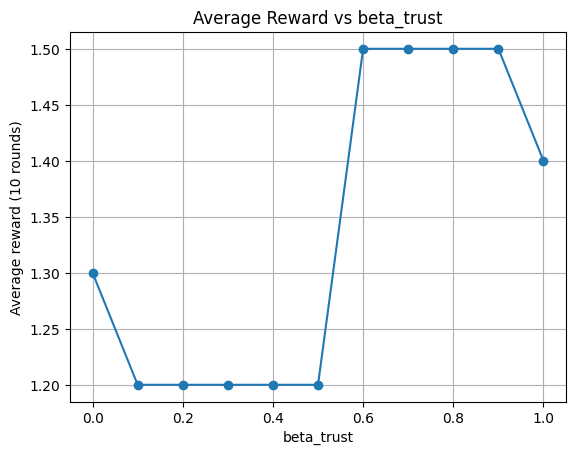

In [4]:

# Line plot: average reward vs beta_trust
plt.figure()
plt.plot(df["beta_trust"], df["avg_reward"], marker="o")
plt.xlabel("beta_trust")
plt.ylabel("Average reward (10 rounds)")
plt.title("Average Reward vs beta_trust")
plt.grid(True)
plt.show()
